In [26]:
from PIL import Image

In [27]:
import torch


In [28]:
from tqdm.auto import tqdm

In [29]:
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config

In [30]:
from point_e.diffusion.sampler import PointCloudSampler

In [31]:
from point_e.models.download import load_checkpoint

In [32]:
from point_e.models.configs import MODEL_CONFIGS, model_from_config

In [33]:
from point_e.util.plotting import plot_point_cloud

In [34]:
import point_e
import point_e.diffusion
import point_e.evals
import point_e.models
import point_e.util
import filelock


In [35]:
import PIL

In [36]:
import torch
import fire
import humanize
import requests
import tqdm
import matplotlib

In [37]:
from skimage import io, color
import scipy
import numpy

In [40]:
import torch
from PIL import Image
from tqdm import tqdm

# Choose device (CUDA if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify base model configuration
base_name = 'base40M'  # Use base300M or base1B for better results

# Create base model and diffusion
print('Creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

# Specify upsample model configuration
upsample_name = 'upsample'

# Create upsample model and diffusion
print('Creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS[upsample_name], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[upsample_name])

# Load checkpoints for base and upsample models
print('Downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('Downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint(upsample_name, device))


Creating base model...


Creating upsample model...


<All keys matched successfully>

In [41]:
# Create PointCloudSampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [43]:
# Load an image to condition on
img = Image.open('C:\\Users\\Archana Jayaraman\\Downloads\\chair.png')

# Produce a sample from the model
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x



130it [1:48:07, 49.91s/it]


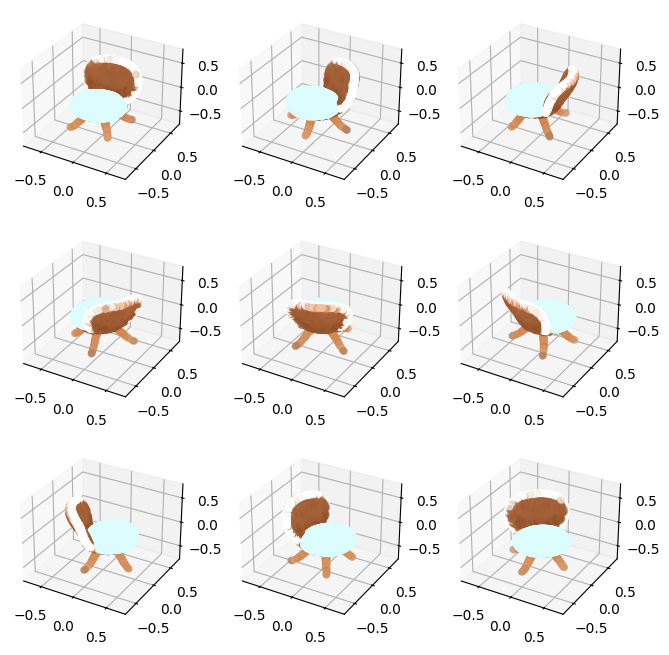

In [44]:
# Convert output to point clouds
pc = sampler.output_to_point_clouds(samples)[0]
# Plot the point cloud
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))


In [45]:
import plotly.graph_objects as go

In [46]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [50]:
import plotly.io as pio
pio.renderers.default = 'vscode'

In [52]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
pyo.iplot(fig)
fig.show()

PlotlyError: The `figure_or_data` positional argument must be `dict`-like, `list`-like, or an instance of plotly.graph_objs.Figure